In [ ]:
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

import scipy.stats as stats
import pandas as pd
from matplotlib.lines import Line2D

import seaborn as sns; sns.set_theme(color_codes=True)

from scipy.stats import pearsonr
import numpy as np
import os, stat

import pickle

Mounted at /content/drive


In [ ]:
def plot_moca_vs_feature(features_df, cognitive_scores_df, demographics_df, y_axis_label,
                         regressor_label, figsize=(6, 6), dot_size=2,
                         line_width=3, label_fontsize=16):
    """
    Plots the cross-sectional scatter plot of MoCA scores against a given feature, colored by participant class.
    Regression is shown and controlled for demographics.

    Args:
        features_df (pd.DataFrame): Contains features and participant class info.
        cognitive_scores_df (pd.DataFrame): Contains the MoCA score info.
        demographics_df (pd.DataFrame): Contains demographic data for participants.
        y_axis_label (str): Column name of the y-axis feature in cognitive_scores_df (typically 'MoCA').
        regressor_label (str): Name of the x-axis feature for regression.
        figsize (tuple, optional): Size of the figure. Default is (6, 6).
        dot_size (int, optional): Dot size in the scatter plot. Default is 50.
        line_width (int, optional): Regression line width. Default is 3.
        label_fontsize (int, optional): Font size for plot labels. Default is 16.

    Returns:
        None. Displays a plot.
    """

    # Merge features and cognitive scores using participant ID
    merged_data = features_df.merge(cognitive_scores_df, on='ID')
    merged_data['Class'] = merged_data['Class_x'].replace({'ADNoEp': 'AD-NoEp', 'ADEp': 'AD-Ep'})

    # Set visual parameters for the plot
    class_colors = {"HC": "#2E8B57", "AD-NoEp": "#00bfff", "AD-Ep": "#000080"}
    plt.rcParams["figure.figsize"] = figsize
    sns.set_theme(style='white')

    # Plot data for each class with distinct colors
    for class_name, color in class_colors.items():
        subset_data = merged_data[merged_data['Class'] == class_name]
        plt.scatter(subset_data[regressor_label], subset_data[y_axis_label],
                    color=color, label=class_name, s=dot_size)

    # Merge demographics with cognitive scores
    relevant_demos = demographics_df.loc[:, demographics_df.columns.str.contains('Age|Sex|Education|ID')]
    cleaned_demos = relevant_demos.dropna()
    merged_demos_cog = cleaned_demos.merge(cognitive_scores_df, on='ID')
    merged_demos_cog = pd.get_dummies(data=merged_demos_cog, columns=['Class', 'Sex'])
    merged_demos_cog = merged_demos_cog.merge(features_df, on='ID')

    # Perform OLS regression while accounting for demographics
    fit = ols(f'MoCA ~ {regressor_label} + C(Sex_F) + C(Sex_M) + Education + Age',
              data=merged_demos_cog).fit()

    # Calculate regression line values
    slope, intercept, _, _, _ = stats.linregress(merged_data[regressor_label], merged_data[y_axis_label])
    x_values = np.array(merged_data[regressor_label])
    y_values = intercept + slope * x_values

    # Calculate the correlation coefficient
    r_value = np.sqrt(fit.rsquared)
    if slope < 0:  # If the slope is negative, adjust the sign of the correlation
        r_value = -r_value

    p_value = fit.f_pvalue

    # Plot regression line with 95% confidence interval
    sns.regplot(x=regressor_label, y=y_axis_label, data=merged_data,
                scatter=False, line_kws={'color': 'black', 'label': f'$R = {r_value:.3f}$, $p = {p_value:.3f}$', 'linewidth': line_width},
                ci=95, truncate=False, scatter_kws={'s':dot_size})

    # Handles for current existing legend items (the dots for each class)
    handles = [Line2D([0], [0], color=color, marker='o', linestyle='', markersize=np.sqrt(dot_size)) for class_name, color in class_colors.items()]

    # Add a custom legend entry for the regression line
    legend_line = Line2D([0], [0], color='black', lw=line_width)
    handles.append(legend_line)

    # Combine labels for the class names and the regression stats
    legend_labels = list(class_colors.keys()) + [f'$R = {r_value:.3f}$, $p = {p_value:.3f}$']

    # Configure plot title and combined legends
    plt.legend(handles, legend_labels, fontsize=label_fontsize)
    plt.xlabel('GE', fontsize=label_fontsize)
    plt.xticks(fontsize=label_fontsize)
    plt.ylabel(y_axis_label, fontsize=label_fontsize)
    plt.yticks(fontsize=label_fontsize)

    # Hide the right and top spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Display the plot
    plt.show()

In [ ]:
# Load data from previous run
def load_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

features = load_data('./features.pickle')

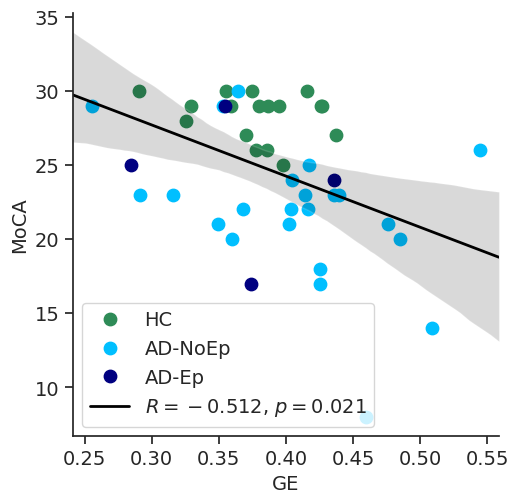

In [ ]:
# MoCA cross-sectional analysis
# Load features data and cognitive outcomes ("1_" = N2, "3_" =  REM, "4_" = Awake)
features_df = features['4_delta']
# Load patients who had MoCA scores within 1 year of their EEG (not converting from MMSE)
cog_df = pd.read_csv('./only_moca.csv')
# Load demographic data
demographics_table = pd.read_csv('./ADEX_demo.csv')

plot_moca_vs_feature(features_df, cog_df, demographics_table, 'MoCA', regressor_label = 'GE_wPLI', figsize=(5.5, 5.5), dot_size=80,
                     line_width=2, label_fontsize=14)